<h1 style=""><font size="3">Model 7: neural network with regularization</font></h1>

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas_datareader.data as web
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


D:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
def get_prices(symbol):
    start, end = '2007-05-02', '2018-12-01'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Close']
    prices=prices.astype(float)
    return prices

def get_returns(prices):
        return ((prices-prices.shift(-1))/prices)[:-1]
    
def get_data(list):
    l = []
    for symbol in list:
        rets = get_returns(get_prices(symbol))
        l.append(rets)
    return np.array(l).T

def sort_data(rets):
    ins = []
    outs = []
    for i in range(len(rets)-100):
        ins.append(rets[i:i+100].tolist())
        outs.append(rets[i+100])
    return np.array(ins), np.array(outs)
        
symbol_list = ['C', 'GS']
rets = get_data(symbol_list)
ins, outs = sort_data(rets)
ins = ins.transpose([0,2,1]).reshape([-1, len(symbol_list) * 100])
div = int(.8 * ins.shape[0])
train_ins, train_outs = ins[:div], outs[:div]
test_ins, test_outs = ins[div:], outs[div:]

#normalize inputs
train_ins, test_ins = train_ins/np.std(ins), test_ins/np.std(ins)

In [7]:
class Model():
    def __init__(self, config, training=True):
        #CONFIG
        symbol_list = self.symbol_list = config.symbol_list
        num_samples = self.num_samples =  config.num_samples
        input_len = self.input_len =  config.input_len
        n_hidden_1 = self.n_hidden_1 =  config.n_hidden_1
        n_hidden_2 = self.n_hidden_2 =  config.n_hidden_2 
        learning_rate = self.learning_rate = config.learning_rate
        
        #bucket info
        positions = self.positions = tf.constant([-1,0,1])
        num_positions = self.num_positions =  3
        
        #more vars
        num_symbols = self.num_symbols =  len(symbol_list)
        n_input = self.n_input = num_symbols * input_len
        n_classes = self.n_classes = num_positions * num_symbols 
        
        x =self.x = tf.placeholder(tf.float32, [None, n_input])
        y_ =self.y_= tf.placeholder(tf.float32, [None,  num_symbols])

        weights = {
            'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
            'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
            'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
        }
        biases = {
            'b1': tf.Variable(tf.random_normal([n_hidden_1])),
            'b2': tf.Variable(tf.random_normal([n_hidden_2])),
            'out': tf.Variable(tf.random_normal([n_classes]))
        }

        
        def multilayer_perceptron(x, weights, biases, keep_prob):
            # Hidden layer with RELU activation
            layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
            layer_1 = tf.nn.relu(layer_1)
            # Hidden layer with RELU activation
            layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
            layer_2 = tf.nn.relu(layer_2)
            # Output layer with linear activation
            out_layer_f = tf.matmul(layer_2, weights['out']) + biases['out']
            out_layer = tf.nn.dropout(out_layer_f, keep_prob)                 # DROPOUT LAYER
            return out_layer
        
        if training == True: keep_prob = 0.5  # DROPOUT
        else: keep_prob = 1.0                 # NO DROPOUT
            
        # Construct model
        y = multilayer_perceptron(x, weights, biases, keep_prob)

        # loop through symbol, taking the columns for each symbol's bucket together
        pos = {}
        sample_n = {}
        sample_mask = {}
        symbol_returns = {}
        relevant_target_column = {}
        for i in range(num_symbols):
            # isolate the buckets relevant to the symbol and get a softmax as well
            symbol_probs = y[:,i*num_positions:(i+1)*num_positions]
            symbol_probs_softmax = tf.nn.softmax(symbol_probs) # softmax[i, j] = exp(logits[i, j]) / sum(exp(logits[i]))
            # sample probability to chose our policy's action
            sample = tf.multinomial(tf.log(symbol_probs_softmax), num_samples)
            for sample_iter in range(num_samples):
                sample_n[i*num_samples + sample_iter] = sample[:,sample_iter]
                pos[i*num_samples + sample_iter] = tf.reshape(sample_n[i*num_samples + sample_iter], [-1]) - 1
                symbol_returns[i*num_samples + sample_iter] = tf.multiply(
                                                                    tf.cast(pos[i*num_samples + sample_iter], float32), 
                                                                     y_[:,i])

                sample_mask[i*num_samples + sample_iter] = tf.cast(tf.reshape(tf.one_hot(sample_n[i*num_samples + sample_iter], 3), [-1,3]), float32)
                relevant_target_column[i*num_samples + sample_iter] = tf.reduce_sum(
                                                            symbol_probs_softmax * sample_mask[i*num_samples + sample_iter],1)
        self.pos = pos

        # PERFORMANCE METRICS
        daily_returns_by_symbol_ = tf.concat(axis=1, values=[tf.reshape(t, [-1,1]) for t in symbol_returns.values()])
        daily_returns_by_symbol = tf.transpose(tf.reshape(daily_returns_by_symbol_, [-1,2,num_samples]), [0,2,1]) #[?,5,2]
        self.daily_returns = daily_returns = tf.reduce_mean(daily_returns_by_symbol, 2) # [?,5]
        
        total_return = tf.reduce_prod(daily_returns+1, 0)
        z = tf.ones_like(total_return) * -1
        self.total_return =total_return= tf.add(total_return, z)
        
        self.ann_vol = ann_vol = tf.multiply(
            tf.sqrt(tf.reduce_mean(tf.pow((daily_returns - tf.reduce_mean(daily_returns, 0)),2),0)) ,
            np.sqrt(252)
            )
        self.sharpe = sharpe = tf.div(total_return, ann_vol)
        #Maybe metric slicing later
        #segment_ids = tf.ones_like(daily_returns[:,0])
        #partial_prod = tf.segment_prod(daily_returns+1, segment_ids)

        training_target_cols = tf.concat(axis=1, values=[tf.reshape(t, [-1,1]) for t in relevant_target_column.values()])
        ones = tf.ones_like(training_target_cols)
        gradient_ = tf.nn.sigmoid_cross_entropy_with_logits(labels=training_target_cols, logits=ones)
        gradient = tf.transpose(tf.reshape(gradient_, [-1,2,num_samples]), [0,2,1]) #[?,5,2]

        #L2  = tf.contrib.layers.l2_regularizer(0.1)
        #t_vars = tf.trainable_variables()
        #reg = tf.contrib.layers.apply_regularization(L2, tf.GraphKeys.WEIGHTS)

        #cost = tf.multiply(gradient , daily_returns_by_symbol_reshaped)
        #cost = tf.multiply(gradient , tf.expand_dims(daily_returns, -1)) #+ reg
        cost = tf.multiply(gradient , tf.expand_dims(total_return, -1))
#         cost = tf.multiply(gradient , tf.expand_dims(sharpe, -1))

        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
        self.costfn = tf.reduce_mean(cost)

In [8]:
class SmallConfig(object):
    """Small config."""
    symbol_list = ['C', 'GS']
    num_samples = 20
    input_len = 100
    n_hidden_1 = 50 
    n_hidden_2 = 50 
    learning_rate = 0.5

In [9]:
if 1==1:
    sess = tf.Session()
    # initialize variables to random values
    with tf.variable_scope("model", reuse=None):
        m = Model(config = SmallConfig)
    with tf.variable_scope("model", reuse=True):
        mvalid = Model(config = SmallConfig, training=False)
    sess.run(tf.global_variables_initializer())

# run optimizer on entire training data set many times
train_size = train_ins.shape[0]
for epoch in range(2000):
    start = rng.randint(train_size-50)
    batch_size = rng.randint(2,75)
    end = min(train_size, start+batch_size)
    
    sess.run(m.optimizer, feed_dict={m.x: train_ins[start:end], m.y_: train_outs[start:end]})#.reshape(1,-1).T})
    # every 1000 iterations record progress
    if np.sqrt(epoch+1)%1== 0:
        t,s, c = sess.run([ mvalid.total_return, mvalid.ann_vol, mvalid.costfn], feed_dict={mvalid.x: train_ins, mvalid.y_: train_outs})#.reshape(1,-1).T})
        t = np.mean(t)
        t = (1+t)**(1/6) -1
        s = np.mean(s)
        s = t/s
        print("Epoch:", '%04d' % (epoch+1), "cost=",c, "total return=", "{:.9f}".format(t), 
             "sharpe=", "{:.9f}".format(s))
        #print(t)

Epoch: 0001 cost= -0.117616646 total return= -0.074312412 sharpe= -0.218865882
Epoch: 0004 cost= -0.11681126 total return= -0.073700300 sharpe= -0.217084975
Epoch: 0009 cost= -0.114505924 total return= -0.071904260 sharpe= -0.211786318
Epoch: 0016 cost= -0.118588574 total return= -0.075051364 sharpe= -0.221005648
Epoch: 0025 cost= -0.113516144 total return= -0.071139580 sharpe= -0.209401491
Epoch: 0036 cost= -0.1182107 total return= -0.074753968 sharpe= -0.220227231
Epoch: 0049 cost= -0.12067809 total return= -0.076676855 sharpe= -0.225897801
Epoch: 0064 cost= -0.11634076 total return= -0.073285516 sharpe= -0.215731062
Epoch: 0081 cost= -0.11348557 total return= -0.071148064 sharpe= -0.209503028
Epoch: 0100 cost= -0.12028972 total return= -0.076383678 sharpe= -0.225101487
Epoch: 0121 cost= -0.11301959 total return= -0.070807367 sharpe= -0.208469147
Epoch: 0144 cost= -0.12086059 total return= -0.076835378 sharpe= -0.226437075
Epoch: 0169 cost= -0.117418386 total return= -0.074135951 sha

In [10]:
# in sample results
#init = tf.initialize_all_variables()
#sess.run(init)
d, t = sess.run([mvalid.daily_returns, mvalid.pos[0]], feed_dict={mvalid.x: train_ins, mvalid.y_: train_outs})

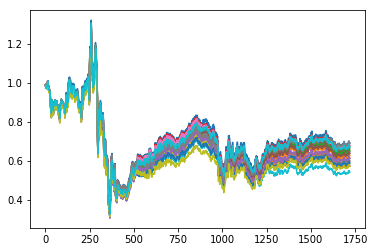

In [11]:
# equity curve
for i in range(mvalid.num_samples):
    plot(np.cumprod(d[:,[i]]+1))

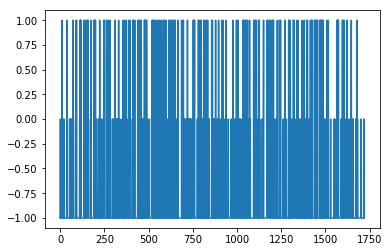

In [12]:
plot(t)

In [13]:
#out of sample results
d, t = sess.run([mvalid.daily_returns, mvalid.pos[0]], feed_dict={mvalid.x: test_ins, mvalid.y_: test_outs})

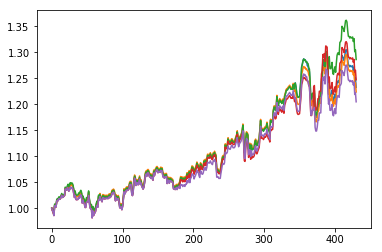

In [14]:
#out of sample results
for i in range(5):
    plot(np.cumprod(d[:,[i]]+1))

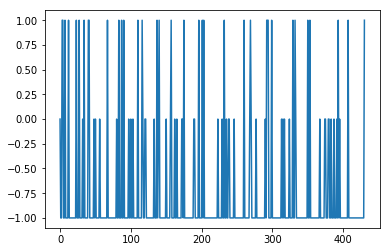

In [15]:
plot(t)